# Model Interpretability
We'll interpret our model's predictions using LIME (Local Interpretable Model-agnostic Explanations). LIME helps us understand which words in a review most strongly influence the model's classification decisions.
We start by copying the necessary code we need from the previous notebook so we can start interpreting using LIME.


In [3]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


processed_path = "../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)
df['label'] = df['polarity'].map({1: 0, 2: 1})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = load_model('../models/cnn/best_model.keras')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

maxlen = 70  


Now we'll use LIME to analyze how the model makes its decisions and then visualize which words contribute most to positive/negative sentiment predictions.
We'll create a prediction function that:
1. Converts text to sequences using our tokenizer
2. Pads sequences to the required length
3. Gets predictions from our model
4. Returns probabilities for both negative and positive classes.

Finally, we'll display the models prediction, showing the original text, the top words that influenced the prediction, and list the contribution score for each word

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

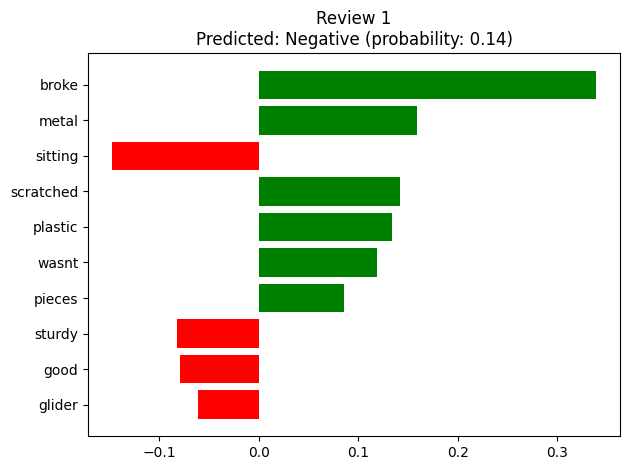


Review 1:
Text: bench bench nice pieces looked like painted scratches metal scratched unsure screws tighten much str...

Top contributing words:
broke: 0.338
metal: 0.159
sitting: -0.147
scratched: 0.141
plastic: 0.133
wasnt: 0.118
pieces: 0.086
sturdy: -0.082
good: -0.079
glider: -0.061


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

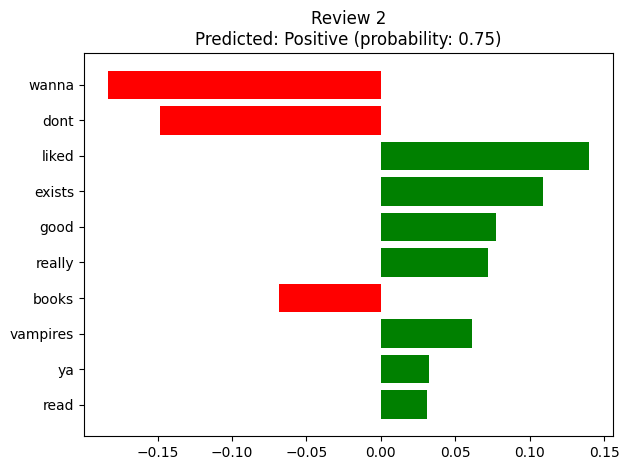


Review 2:
Text: totally witchy actually 3nd night worlds ever read different cover says enchantress good book liked ...

Top contributing words:
wanna: -0.183
dont: -0.149
liked: 0.140
exists: 0.109
good: 0.077
really: 0.072
books: -0.068
vampires: 0.061
ya: 0.032
read: 0.031


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

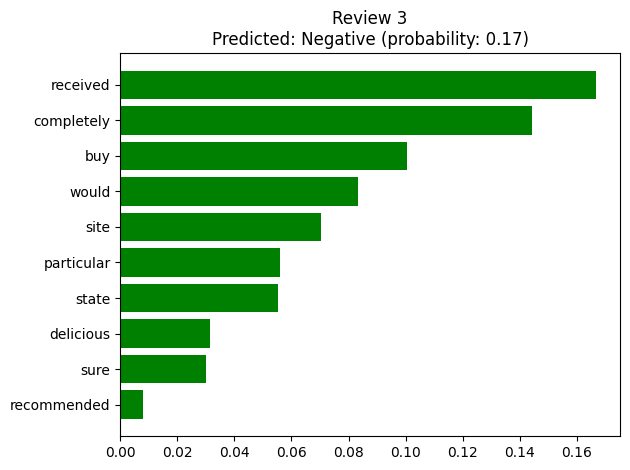


Review 3:
Text: received melted sure delicious recommended mehowever completely melted received thepackage state per...

Top contributing words:
received: 0.167
completely: 0.144
buy: 0.100
would: 0.083
site: 0.070
particular: 0.056
state: 0.055
delicious: 0.031
sure: 0.030
recommended: 0.008


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

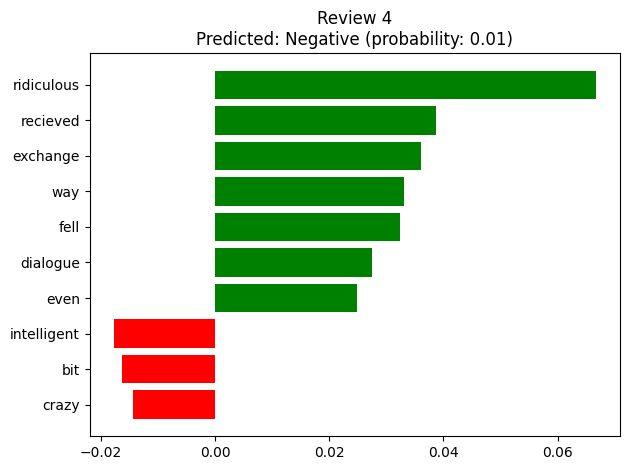


Review 4:
Text: melissas eclectic bookshelf reviews dnf thoughts expected fun quick read adore simplicity coverthe t...

Top contributing words:
ridiculous: 0.067
recieved: 0.039
exchange: 0.036
way: 0.033
fell: 0.032
dialogue: 0.027
even: 0.025
intelligent: -0.018
bit: -0.016
crazy: -0.014


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

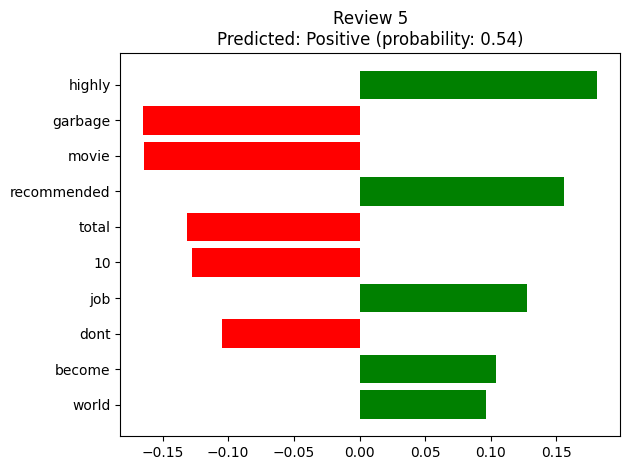


Review 5:
Text: 1 star since theres zero stars available cant believe reviewer turned first 30 minutes world anyone ...

Top contributing words:
highly: 0.181
garbage: -0.165
movie: -0.164
recommended: 0.155
total: -0.132
10: -0.128
job: 0.127
dont: -0.105
become: 0.104
world: 0.096




In [4]:
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

#function to predict probabilities
def predict_prob(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    preds = best_model.predict(padded)
    return np.array([[1-p[0], p[0]] for p in preds])

#create LIME explainer and get sample texts
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
num_examples = 5
sample_indices = np.random.choice(len(X_test), num_examples)
sample_texts = X_test.iloc[sample_indices].values

#nalyze each example
for idx, text in enumerate(sample_texts):
    exp = explainer.explain_instance(
        text, 
        predict_prob,
        num_features=10,
        top_labels=1
    )
    
    pred_probs = predict_prob([text])[0]
    pred_class = 'Positive' if pred_probs[1] > 0.5 else 'Negative'
    explained_label = exp.available_labels()[0]
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure(label=explained_label)
    plt.title(f'Review {idx+1}\nPredicted: {pred_class} (probability: {pred_probs[1]:.2f})')
    plt.tight_layout()
    plt.show()
    
    print(f"\nReview {idx+1}:")
    print(f"Text: {text[:100]}...")
    print("\nTop contributing words:")
    for word, score in exp.as_list(label=explained_label):
        print(f"{word}: {score:.3f}")
    print("\n" + "="*50 + "\n")